In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
(mnist_x_train,mnist_y_train),(mnist_x_test,mnist_y_test) = tf.keras.datasets.mnist.load_data()
(cf_x_train,cf_y_train),(cf_x_test,cf_y_test) = tf.keras.datasets.cifar10.load_data()

In [2]:
#Convert all values between 0 and 1, by dividing by 255.0
#This will help prevent saturation of neurons
mnist_x_train = mnist_x_train/255.0
mnist_x_test = mnist_x_test/255.0
cf_x_train = cf_x_train/255.0
cf_x_test = cf_x_test/255.0
#Reshape mnist to be [numsamples,edge_size,edge_size,num_channels] just like cifar10
mnist_x_train = mnist_x_train.reshape([-1,28,28,1])
mnist_x_test = mnist_x_test.reshape([-1,28,28,1])

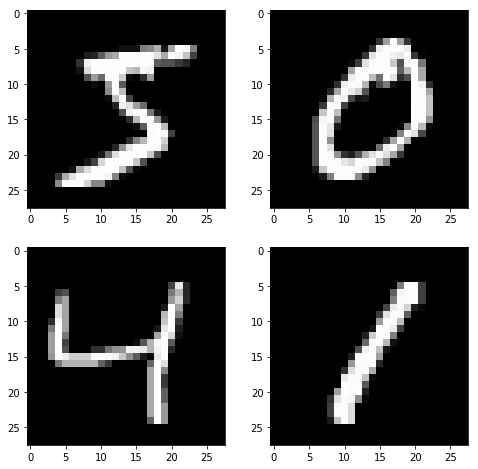

In [3]:
#mnist - Examples
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(mnist_x_train[i].reshape([28,28]),cmap="gray")

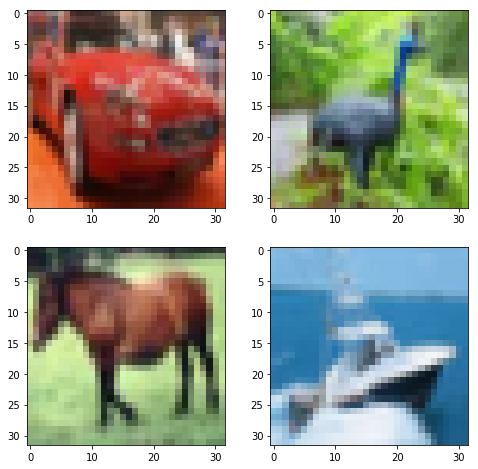

In [4]:
#cifar10 - Examples
plt.figure(figsize=(8, 8))
i=0
for j in range(5,9):
    plt.subplot(2,2,i+1)
    plt.imshow(cf_x_train[j])
    i+=1

# Convolutional VAE on mnist

In [5]:
#Define general VAE
batch_size = 50
KLloss_weight = 1
zdim=2
learning_rate=0.001

class VAE(object):
    def __init__(self, zdim=zdim, lr=learning_rate, batch_size=batch_size):
        self.lr = lr
        self.batch_size = batch_size
        self.zdim = zdim
        self.build()

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def encoder(self, x):
        with tf.variable_scope('encoder'):
            x = tf.reshape(x, shape=[-1,edge_size,edge_size,num_chan])
            conv1 = tf.layers.conv2d(x, filters=32, kernel_size=3, activation=tf.nn.relu)
            conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

            conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=3, activation=tf.nn.relu)
            conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

            flat = tf.contrib.layers.flatten(conv2)
            fc_layer1 = tf.layers.dense(flat, 256, name='layer1', activation=tf.nn.relu)
            fc_layer2 = tf.layers.dense(fc_layer1, 64, name='layer2', activation=tf.nn.relu)

        mu = tf.layers.dense(fc_layer2, self.zdim, name='mu')
        logsigma = tf.layers.dense(fc_layer2, self.zdim, name='logsigma')

        return mu, logsigma

    def decoder(self, z):
        with tf.variable_scope('decoder'):
            fc_layer1 = tf.layers.dense(z, 64, name='layer1', activation=tf.nn.relu)
            fc_layer2 = tf.layers.dense(fc_layer1, 256, name='layer2', activation=tf.nn.relu)
            fc_layer2 = tf.reshape(fc_layer2,shape=[-1,16,16,1])
            
            conv1 = tf.layers.conv2d_transpose(fc_layer2,filters=64,kernel_size=3,activation=tf.nn.relu)
            conv2 = tf.layers.conv2d_transpose(conv1,filters=32,kernel_size=3,activation=tf.nn.relu)
            conv2 = tf.contrib.layers.flatten(conv2)

        xhat = tf.layers.dense(conv2, edge_size*edge_size*num_chan, name='finallayer', activation=tf.sigmoid)
        xhat = tf.reshape(xhat,[-1,edge_size,edge_size,num_chan])

        return xhat

    
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, edge_size,edge_size,num_chan])

        # encoder
        mu, logsigma = self.encoder(self.x)
        
        self.mu = mu
        self.logsigma = logsigma

        # sample from random normal
        eps = tf.random_normal(shape=tf.shape(logsigma), mean=0, stddev=1)
        #reparameterization
        z = mu + tf.sqrt(tf.exp(logsigma)) * eps

        # decoder
        self.xhat = self.decoder(z)
        
        #reconstruction loss
        recon_loss = tf.reduce_sum(tf.pow(self.x - self.xhat, 2))      
        #KL divergence loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + logsigma - tf.pow(mu,2) - tf.pow(tf.exp(logsigma),2), axis=-1)

        self.loss_op = tf.reduce_mean(recon_loss) + KLloss_weight*tf.reduce_mean(kl_loss)
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss_op)

    #Here I train the Convolutional VAE    
    def train(self, x):
        self.sess.run(self.train_op, feed_dict={self.x: x})
        
    #Here I evaluate the current loss
    def evaluate(self, x):
        loss = self.sess.run(self.loss_op, feed_dict={self.x: x})
        return loss
    
    #Here I want to try and get the latent space representation, so I can then visualize
    #Not working currently
    def latent_rep(self, x):
        latent,_ = self.sess.run([self.mu,self.logsigma], feed_dict={self.x: x})
        return latent,_
    
    #Here I get the reconstruction of any input data
    def get_reconstruction(self, x):
        xhat = self.sess.run(self.xhat, feed_dict={self.x: x})
        return xhat

In [13]:
edge_size = 28
num_chan = 1
#input_dim = 28x28
epochs=10
learning_rate=0.0001

tf.reset_default_graph()

vae = VAE()

mnist_losses=np.array([])
mnist_reconstruction_stages=[]
for i in range(epochs):
    print("Epoch {} / {}".format(i, epochs))
    r_ind=list(range(0,len(mnist_x_train)))
    random.shuffle(r_ind)
    n=batch_size
    batches = [r_ind[i:i + n] for i in range(0, len(mnist_x_train), n)]
    for j in range(len(batches)):
            vae.train(mnist_x_train[batches[j]])
            if j % 50 == 0:
                loss = vae.evaluate(mnist_x_train[batches[j]])
                mnist_losses = np.append(mnist_losses,loss)

Epoch 0 / 10
Epoch 1 / 10
Epoch 2 / 10
Epoch 3 / 10
Epoch 4 / 10
Epoch 5 / 10
Epoch 6 / 10
Epoch 7 / 10
Epoch 8 / 10
Epoch 9 / 10


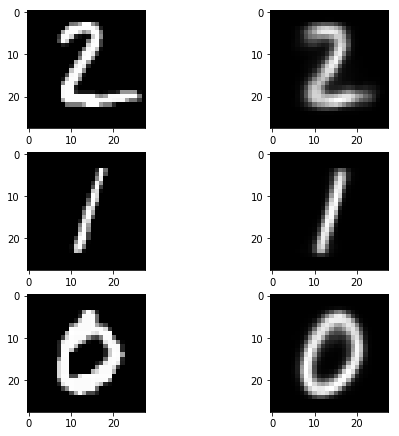

In [14]:
#Here are some reconstructions from the training images
x_reconstruct = vae.get_reconstruction(mnist_x_test[:100])

plt.figure(figsize=(8, 10))
k=1
for i in range(1,4):
    plt.subplot(4,2,k)
    plt.imshow(mnist_x_test[i].reshape([28,28]),cmap="gray")
    k=k+1
    plt.subplot(4,2,k)
    plt.imshow(x_reconstruct[i].reshape([28,28]),cmap="gray")
    k=k+1

In [11]:
mu, logsigma = vae.latent_rep(mnist_x_test)

In [12]:
eps=np.random.normal(mu.shape[1],0,1)
z=mu+np.sqrt(np.exp(logsigma))*eps

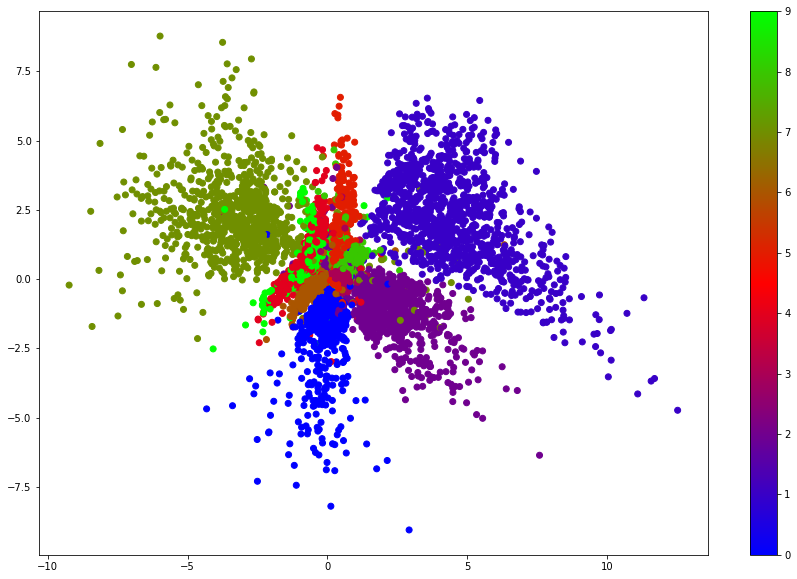

In [13]:
plt.figure(figsize=(15,10))
plt.scatter(z[:,0],z[:,1],c=mnist_y_test,cmap="brg")
plt.colorbar()

# Same Convolutional VAE on cifar-10

In [31]:
batch_size = 50
edge_size = 32
num_chan = 3
#input_dim = 32*32*3
epochs=10
learning_rate=0.0001
KLloss_weight=1

tf.reset_default_graph()

vae = VAE()

cf_losses=np.array([])
cf_reconstruction_stages=[]
for i in range(epochs):
    print("Epoch {} / {}".format(i, epochs))
    r_ind=list(range(0,len(cf_x_train)))
    random.shuffle(r_ind)
    n=batch_size
    batches = [r_ind[i:i + n] for i in range(0, len(cf_x_train), n)]
    for j in range(len(batches)):
            vae.train(cf_x_train[batches[j]])
            if j % 50 == 0:
                loss = vae.evaluate(cf_x_train[batches[j]])
                cf_losses = np.append(cf_losses,loss)
                #print("Batch: {}, Loss: {}".format(j,loss))
#            if j % (len(batches)/2) == 0:
#                x_reconstruct = vae.get_reconstruction(cf_x_test[:100])
#                cf_reconstruction_stages.append(x_reconstruct)

Epoch 0 / 10
Epoch 1 / 10
Epoch 2 / 10
Epoch 3 / 10
Epoch 4 / 10
Epoch 5 / 10
Epoch 6 / 10
Epoch 7 / 10
Epoch 8 / 10
Epoch 9 / 10


In [33]:
mu, logsigma = vae.latent_rep(cf_x_test)

In [34]:
eps=np.random.normal(mu.shape[1],0,1)
z=mu+np.sqrt(np.exp(logsigma))*eps

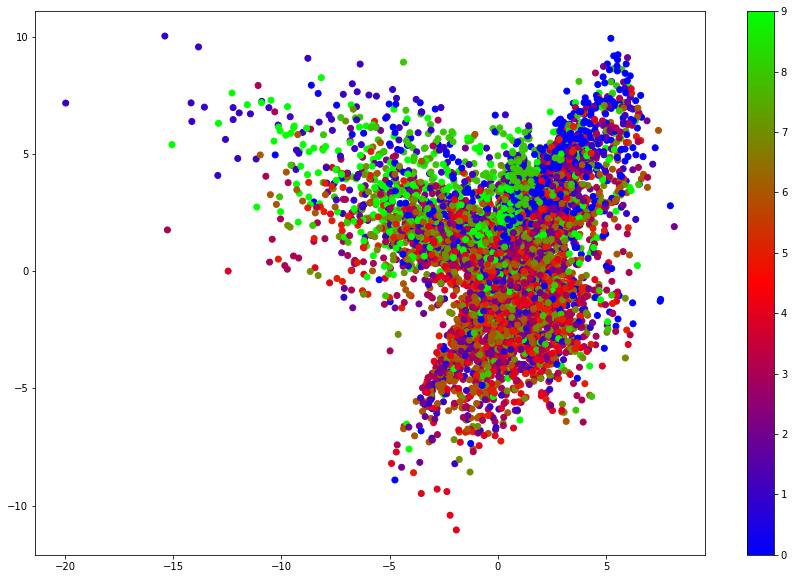

In [35]:
plt.figure(figsize=(15,10))
plt.scatter(z[:,0],z[:,1],c=cf_y_test.reshape([10000,]),cmap="brg")
plt.colorbar()

# Let's try to reconstruct with better accuracy
Increase the incoding dimension for reconstruction.

In [20]:
#Define general VAE
batch_size = 50
zdim=16
learning_rate=0.0001

class hd_VAE(object):
    def __init__(self, zdim=zdim, lr=learning_rate, batch_size=batch_size):
        self.lr = lr
        self.batch_size = batch_size
        self.zdim = zdim
        self.build()

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def encoder(self, x):
        with tf.variable_scope('encoder'):
            x = tf.reshape(x, shape=[-1,edge_size,edge_size,num_chan])
            conv1 = tf.layers.conv2d(x, filters=32, kernel_size=3, activation=tf.nn.relu)
            conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

            conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=3, activation=tf.nn.relu)
            conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

            flat = tf.contrib.layers.flatten(conv2)
            fc_layer1 = tf.layers.dense(flat, 256, name='layer1', activation=tf.nn.relu)
            fc_layer2 = tf.layers.dense(fc_layer1, 64, name='layer2', activation=tf.nn.relu)

        mu = tf.layers.dense(fc_layer2, self.zdim, name='mu')
        logsigma = tf.layers.dense(fc_layer2, self.zdim, name='logsigma')

        return mu, logsigma

    def decoder(self, z):
        with tf.variable_scope('decoder'):
            fc_layer1 = tf.layers.dense(z, 64, name='layer1', activation=tf.nn.relu)
            fc_layer2 = tf.layers.dense(fc_layer1, 256, name='layer2', activation=tf.nn.relu)
            fc_layer2 = tf.reshape(fc_layer2,shape=[-1,16,16,1])
            
            conv1 = tf.layers.conv2d_transpose(fc_layer2,filters=64,kernel_size=3,activation=tf.nn.relu)
            conv2 = tf.layers.conv2d_transpose(conv1,filters=32,kernel_size=3,activation=tf.nn.relu)
            conv2 = tf.contrib.layers.flatten(conv2)

        xhat = tf.layers.dense(conv2, edge_size*edge_size*num_chan, name='finallayer', activation=tf.sigmoid)
        xhat = tf.reshape(xhat,[-1,edge_size,edge_size,num_chan])

        return xhat

    
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, edge_size,edge_size,num_chan])

        # encoder
        mu, logsigma = self.encoder(self.x)
        
        self.mu = mu
        self.logsigma = logsigma

        # sample from random normal
        eps = tf.random_normal(shape=tf.shape(logsigma), mean=0, stddev=1)
        #reparameterization
        z = mu + tf.sqrt(tf.exp(logsigma)) * eps

        # decoder
        self.xhat = self.decoder(z)
        
        #reconstruction loss
        recon_loss = tf.reduce_sum(tf.pow(self.x - self.xhat, 2))
        #kl_loss = - 0.5 * tf.reduce_sum(1 + logsigma - tf.pow(mu,2) - tf.pow(tf.exp(logsigma),2), axis=-1)
        
        #No KL loss because we arent worried about latent space representation
        self.loss_op = tf.reduce_mean(recon_loss) #+ tf.reduce_mean(kl_loss)
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss_op)

    #Here I train the Convolutional VAE    
    def train(self, x):
        self.sess.run(self.train_op, feed_dict={self.x: x})
        
    #Here I evaluate the current loss
    def evaluate(self, x):
        loss = self.sess.run(self.loss_op, feed_dict={self.x: x})
        return loss
    
    #Here I get the reconstruction of any input data
    def get_reconstruction(self, x):
        xhat = self.sess.run(self.xhat, feed_dict={self.x: x})
        return xhat

In [21]:
batch_size = 50
edge_size = 32
num_chan = 3
#input_dim = 32*32*3
epochs=50
learning_rate=0.0001

tf.reset_default_graph()

hd_vae = hd_VAE()

highd_cf_losses=np.array([])
highd_cf_reconstruction_stages=[]
for i in range(epochs):
    print("Epoch {} / {}".format(i, epochs))
    r_ind=list(range(0,len(cf_x_train)))
    random.shuffle(r_ind)
    n=batch_size
    batches = [r_ind[i:i + n] for i in range(0, len(cf_x_train), n)]
    for j in range(len(batches)):
            hd_vae.train(cf_x_train[batches[j]])
            if j % 50 == 0:
                loss = hd_vae.evaluate(cf_x_train[batches[j]])
                highd_cf_losses = np.append(highd_cf_losses,loss)
                print("Batch: {}, Loss: {}".format(j,loss))
            if j % (len(batches)/2) == 0:
                x_reconstruct = hd_vae.get_reconstruction(cf_x_test[:100])
                highd_cf_reconstruction_stages.append(x_reconstruct)

Epoch 0 / 10
Batch: 0, Loss: 9600.9091796875
Batch: 50, Loss: 9145.3125
Batch: 100, Loss: 9398.580078125
Batch: 150, Loss: 7723.14453125
Batch: 200, Loss: 6393.56982421875
Batch: 250, Loss: 6451.837890625
Batch: 300, Loss: 5287.9169921875
Batch: 350, Loss: 5267.8623046875
Batch: 400, Loss: 5090.4013671875
Batch: 450, Loss: 4461.4248046875
Batch: 500, Loss: 4196.248046875
Batch: 550, Loss: 4034.390625
Batch: 600, Loss: 4455.0673828125
Batch: 650, Loss: 4362.216796875
Batch: 700, Loss: 4424.6669921875
Batch: 750, Loss: 3972.177490234375
Batch: 800, Loss: 4208.0146484375
Batch: 850, Loss: 3588.96826171875
Batch: 900, Loss: 3677.176513671875
Batch: 950, Loss: 4037.5205078125
Epoch 1 / 10
Batch: 0, Loss: 3699.197265625
Batch: 50, Loss: 3265.60546875
Batch: 100, Loss: 4003.79443359375
Batch: 150, Loss: 3826.085205078125
Batch: 200, Loss: 3768.472900390625
Batch: 250, Loss: 3588.85693359375
Batch: 300, Loss: 3300.276123046875
Batch: 350, Loss: 3380.17333984375
Batch: 400, Loss: 3966.604492187

# VAE for cifar-10 with additional layers
Hopefully, improved reconstruction and latent space representation (compared to the original VAE). I also added decreased weight on the KL weight loss to hopefully spread the latent distributions more.

In [22]:
#Define new VAE with more layers and more filters/neurons
class newVAE(object):
    def __init__(self, zdim=2, lr=learning_rate, batch_size=batch_size):
        self.lr = lr
        self.batch_size = batch_size
        self.zdim = zdim
        self.build()

        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())

    def encoder(self, x):
        with tf.variable_scope('encoder'):
            x = tf.reshape(x, shape=[-1,edge_size,edge_size,num_chan])
            conv1 = tf.layers.conv2d(x, filters=32, kernel_size=3, activation=tf.nn.relu)
            conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

            conv2 = tf.layers.conv2d(conv1, filters=128, kernel_size=3, activation=tf.nn.relu)
            conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

            flat = tf.contrib.layers.flatten(conv2)
            fc_layer1 = tf.layers.dense(flat, 1024, name='layer1', activation=tf.nn.relu)
            fc_layer2 = tf.layers.dense(fc_layer1, 256, name='layer2', activation=tf.nn.relu)
            fc_layer3 = tf.layers.dense(fc_layer1, 32, name='layer3', activation=tf.nn.relu)

        mu = tf.layers.dense(fc_layer3, self.zdim, name='mu')
        logsigma = tf.layers.dense(fc_layer3, self.zdim, name='logsigma')

        return mu, logsigma

    def decoder(self, z):
        with tf.variable_scope('decoder'):
            fc_layer1 = tf.layers.dense(z, 32, name='layer1', activation=tf.nn.relu)
            fc_layer2 = tf.layers.dense(fc_layer1, 256, name='layer2', activation=tf.nn.relu)
            fc_layer3 = tf.layers.dense(fc_layer1, 1024, name='layer3', activation=tf.nn.relu)
            fc_layer3 = tf.reshape(fc_layer3,shape=[-1,32,32,1])
            
            conv1 = tf.layers.conv2d_transpose(fc_layer3,filters=128,kernel_size=3,activation=tf.nn.relu)
            conv2 = tf.layers.conv2d_transpose(conv1,filters=32,kernel_size=3,activation=tf.nn.relu)
            conv2 = tf.contrib.layers.flatten(conv2)

        xhat = tf.layers.dense(conv2, edge_size*edge_size*num_chan, name='finallayer', activation=tf.sigmoid)
        xhat = tf.reshape(xhat,[-1,edge_size,edge_size,num_chan])

        return xhat

    
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, edge_size,edge_size,num_chan])

        # encoder
        mu, logsigma = self.encoder(self.x)
        
        self.mu = mu
        self.logsigma = logsigma

        # sample from random normal
        eps = tf.random_normal(shape=tf.shape(logsigma), mean=0, stddev=1)
        #reparameterization
        z = mu + tf.sqrt(tf.exp(logsigma)) * eps

        # decoder
        self.xhat = self.decoder(z)
        
        #reconstruction loss
        recon_loss = tf.reduce_sum(tf.pow(self.x - self.xhat, 2))      
        #KL divergence loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + logsigma - tf.pow(mu,2) - tf.pow(tf.exp(logsigma),2), axis=-1)

        self.loss_op = tf.reduce_mean(recon_loss) + KLloss_weight*tf.reduce_mean(kl_loss)
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss_op)

    #Here I train the Convolutional VAE    
    def train(self, x):
        self.sess.run(self.train_op, feed_dict={self.x: x})
        
    #Here I evaluate the current loss
    def evaluate(self, x):
        loss = self.sess.run(self.loss_op, feed_dict={self.x: x})
        return loss
    
    #Here I want to try and get the latent space representation, so I can then visualize
    #Not working currently
    def latent_rep(self, x):
        latent,_ = self.sess.run([self.mu,self.logsigma], feed_dict={self.x: x})
        return latent,_
    
    #Here I get the reconstruction of any input data
    def get_reconstruction(self, x):
        xhat = self.sess.run(self.xhat, feed_dict={self.x: x})
        return xhat

In [23]:
batch_size = 50
edge_size = 32
num_chan = 3
#input_dim = 32*32*3
epochs=10
learning_rate=0.0001
KLloss_weight=0.5 #Decreased weight for better representation

tf.reset_default_graph()

newvae = newVAE()

new_cf_losses=np.array([])
new_cf_reconstruction_stages=[]
for i in range(epochs):
    print("Epoch {} / {}".format(i, epochs))
    r_ind=list(range(0,len(cf_x_train)))
    random.shuffle(r_ind)
    n=batch_size
    batches = [r_ind[i:i + n] for i in range(0, len(cf_x_train), n)]
    for j in range(len(batches)):
            newvae.train(cf_x_train[batches[j]])
            if j % 50 == 0:
                loss = newvae.evaluate(cf_x_train[batches[j]])
                new_cf_losses = np.append(new_cf_losses,loss)
                print("Batch: {}, Loss: {}".format(j,loss))
            if j % (len(batches)/2) == 0:
                x_reconstruct = newvae.get_reconstruction(cf_x_test[:100])
                new_cf_reconstruction_stages.append(x_reconstruct)

Epoch 0 / 10
Batch: 0, Loss: 9947.2919921875
Batch: 50, Loss: 6980.1748046875
Batch: 100, Loss: 7059.3037109375
Batch: 150, Loss: 6268.244140625
Batch: 200, Loss: 6106.94140625
Batch: 250, Loss: 6698.86767578125
Batch: 300, Loss: 5977.2802734375
Batch: 350, Loss: 5529.25732421875
Batch: 400, Loss: 6288.40771484375
Batch: 450, Loss: 5952.31884765625
Batch: 500, Loss: 6283.81201171875
Batch: 550, Loss: 6205.6123046875
Batch: 600, Loss: 5260.8232421875
Batch: 650, Loss: 5002.8291015625
Batch: 700, Loss: 5814.6826171875
Batch: 750, Loss: 5594.587890625
Batch: 800, Loss: 6905.10205078125
Batch: 850, Loss: 5877.9443359375
Batch: 900, Loss: 5774.384765625
Batch: 950, Loss: 5755.09130859375
Epoch 1 / 10
Batch: 0, Loss: 6314.93994140625
Batch: 50, Loss: 5881.92578125
Batch: 100, Loss: 5516.46337890625
Batch: 150, Loss: 5807.3994140625
Batch: 200, Loss: 5474.66162109375
Batch: 250, Loss: 5829.32177734375
Batch: 300, Loss: 6178.404296875
Batch: 350, Loss: 5781.07373046875
Batch: 400, Loss: 5903.2

In [24]:
mu, logsigma = newvae.latent_rep(cf_x_test)

In [25]:
eps=np.random.normal(mu.shape[1],0,1)
z=mu+np.sqrt(np.exp(logsigma))*eps

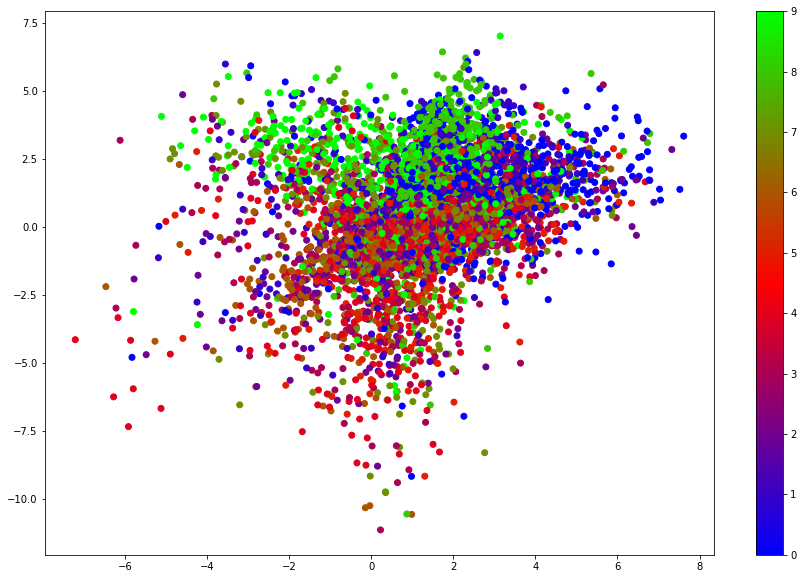

In [26]:
plt.figure(figsize=(15,10))
plt.scatter(z[:,0],z[:,1],c=cf_y_test.reshape([10000,]),cmap="brg")
plt.colorbar()

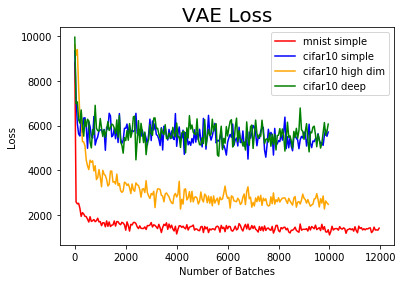

In [32]:
cf_xvals=range(0,int(len(cf_x_train)/50*epochs),50)
mnist_xvals=range(0,int(len(mnist_x_train)/50*epochs),50)

plt.plot(mnist_xvals,mnist_losses,color="red",label="mnist simple")
plt.plot(cf_xvals,cf_losses,color="blue",label="cifar10 simple")
plt.plot(cf_xvals,highd_cf_losses,color="orange",label="cifar10 high dim")
plt.plot(cf_xvals,new_cf_losses,color="green",label="cifar10 deep")
plt.title("VAE Loss",{'fontsize':20})
plt.xlabel("Number of Batches")
plt.ylabel("Loss")
plt.legend()

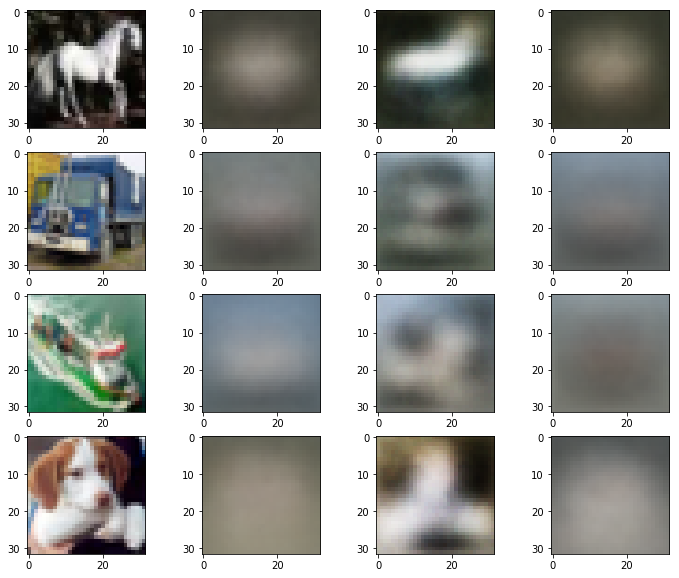

In [38]:
#Here are some reconstructions from the training images
x_reconstruct = vae.get_reconstruction(cf_x_test[:100])
hd_reconstruct = hd_vae.get_reconstruction(cf_x_test[:100])
deep_reconstruct = newvae.get_reconstruction(cf_x_test[:100])

plt.figure(figsize=(12, 10))
k=1
for i in range(13,17):
    plt.subplot(4,4,k)
    plt.imshow(cf_x_test[i])
    k=k+1
    plt.subplot(4,4,k)
    plt.imshow(x_reconstruct[i])
    k=k+1
    plt.subplot(4,4,k)
    plt.imshow(hd_reconstruct[i])
    k=k+1
    plt.subplot(4,4,k)
    plt.imshow(deep_reconstruct[i])
    k=k+1